# Movement prediction with Tensorflow
## Read training data

In [1]:
import numpy as np
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [44]:
# Convert PIL image to 200x200 array normalised to -0.5 to 0.5 rage.
def image_2_array(filename):
    # PIL image pil_img
    pil_img=Image.open(filename)
    pil_arr=np.array(pil_img)
    pil_max = np.amax(np.absolute(pil_arr))
    pil_min = np.amin(np.absolute(pil_arr))
    #print ("Max/min:"+ str(pil_max)+"/"+str(pil_min))
    if pil_max == 0:
        print("Max is 0.")
        return pil_img,pil_arr
    pil_scaled_arr = (pil_arr / pil_max) - 0.5
    return pil_img,pil_scaled_arr

# Invert normalised PIL image
def invert_array(arr):
    #print(arr.shape)
    #print(arr[100][50:60])
    inverted_arr = arr * (-1)
    #print(inverted_arr[100][50:60])
    return inverted_arr
    
# Convert normalized array to PIL image
def array_2_image(arr):
    MAX = 255
    arr_scaled = (arr + 0.5) * MAX
    arr_max = np.amax(arr_scaled)
    arr_min = np.amin(arr_scaled)
    #print ("Array Max/min:"+ str(arr_max)+"/"+str(arr_min))
    im = Image.fromarray(arr_scaled)
    return im

# I. Image inversion

In [22]:
# Prepare inversed images
plot = False
save = False  # Only need to save once
if save:
    for dataset in range(1, 11):
        for img_counter in range(1, 11):
            # Read Image
            dataset_str = str(dataset).zfill(3)
            image_str = str(img_counter).zfill(4)
            filename = "/notebooks/data001/move" + \
                    dataset_str+"_"+image_str+".gif"
            #print filename
            img,a = image_2_array(filename)
            #print("Orgarr:")
            #print(a)


            in_arr = invert_array(a)
            #print("Invarr:")
            #print(in_arr)
            new_im = array_2_image(in_arr)
            new_filename = "/notebooks/data001/move_inv_" + \
                    dataset_str+"_"+image_str+".gif"
            # Save new image to file
            new_im.save(new_filename, "GIF")
            # Plot
            if (plot):
                _, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
                ax1.imshow(img);
                ax2.imshow(a, vmin=-0.5, vmax=0.5,cmap=plt.cm.Greys);
                ax3.imshow(in_arr, cmap=plt.cm.Greys);
                ax4.imshow(new_im);



## Test cross-entropy function

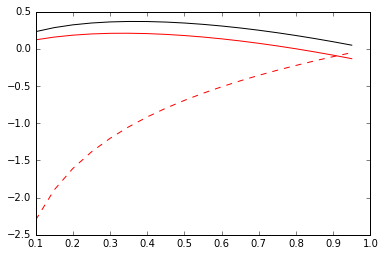

In [19]:
# evenly sampled at 0.2 intervals
y = np.arange(0.1, 1., 0.05)
z = np.log(y)
H = -y*z
Hr = -y*np.log(y+0.2)
plt.plot(y, z, 'r--', y, H, 'k', y, Hr, 'r')
plt.show()

# Prepare training set

In [46]:
# Read training images into array of shape (80, 200, 200, 1)
IMSIZE=200
train_data_onedimension = np.array([]) #np.empty([80,200,200,1])
train_labl_onedimension = np.array([])
for dataset in range(1, 9):
    for img_counter in range(1, 11):
        dataset_str = str(dataset).zfill(3)
        image_str = str(img_counter).zfill(4)
        filename = "/notebooks/data001/move" + \
                dataset_str+"_"+image_str+".gif"
        #print filename
        img,a = image_2_array(filename)
        
        train_data_onedimension = np.append(train_data_onedimension,a)
        # Targets
        filename = "/notebooks/data001/move_inv_" + \
                dataset_str+"_"+image_str+".gif"
        #print filename
        img,a = image_2_array(filename)
        train_labl_onedimension = np.append(train_labl_onedimension,a)
        
        
print train_data_onedimension.shape
print train_labl_onedimension.shape

images_in_set = train_data_onedimension.size / (IMSIZE*IMSIZE)
print images_in_set
train_data = train_data_onedimension.reshape(images_in_set, IMSIZE, IMSIZE, 1)
print train_data.shape
train_labl = train_labl_onedimension.reshape(images_in_set, IMSIZE, IMSIZE, 1)
print train_labl.shape

Max is 0.
Max is 0.
Max is 0.
Max is 0.
Max is 0.
Max is 0.
Max is 0.
Max is 0.
(3200000,)
(3200000,)
80
(80, 200, 200, 1)
(80, 200, 200, 1)


## Configure DNN

In [70]:
import tensorflow as tf

# Set max value to be 1
def normalise(y):
    max_v = np.amax(y)
    return y/max_v
    

$$y = Wx + b$$

In [83]:
# Length of one image in elements
image_len = IMSIZE*IMSIZE
x = tf.placeholder(tf.float32, [None, image_len])
W = tf.Variable(tf.zeros([image_len, image_len]))
b = tf.Variable(tf.zeros([image_len]))
y = tf.matmul(x, W) + b
# Add print operation
y = tf.Print(y, [y], message="y= ")
y_ = tf.placeholder(tf.float32, [None, image_len])

# Cost function

In [99]:
J = -tf.reduce_sum((y_ - y)*(y_ - y),reduction_indices=[1])

In [103]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(J)
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
BATCHSIZE=1


In [104]:
def get_next_batch(data,i,BATCHSIZE,IMSIZE):
    image_len = IMSIZE*IMSIZE
    batch_len = BATCHSIZE*image_len
    start_index = i*batch_len
    end_index = i*batch_len + batch_len
    return data[start_index:end_index].reshape(BATCHSIZE,image_len)

In [105]:
with sess.as_default():   # or `with sess:` to close on exit
    assert sess is tf.get_default_session()
    batchX = get_next_batch(train_data_onedimension,0,BATCHSIZE,IMSIZE)
    print(batchX)
    print(batchX.shape)
    batchY = get_next_batch(train_labl_onedimension,0,BATCHSIZE,IMSIZE)
    print(batchY)
    print(batchY.shape)
    sess.run(train_step, feed_dict={x: batchX, y_: batchY})
    y.eval()

[[-0.5 -0.5 -0.5 ...,  0.5  0.5  0.5]]
(1, 40000)
[[ 0.5  0.5  0.5 ..., -0.5 -0.5 -0.5]]
(1, 40000)


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_14' with dtype float
	 [[Node: Placeholder_14 = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
Caused by op u'Placeholder_14', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-83-0d97e1ef839d>", line 3, in <module>
    x = tf.placeholder(tf.float32, [None, image_len])
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/array_ops.py", line 762, in placeholder
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 976, in _placeholder
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/op_def_library.py", line 655, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2154, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1154, in __init__
    self._traceback = _extract_stack()


In [ ]:
for i in range(int(images_in_set/BATCHSIZE)):
    print(i)
    batchX = get_next_batch(train_data_onedimension,i,BATCHSIZE,IMSIZE)
    batchY = get_next_batch(train_labl_onedimension,i,BATCHSIZE,IMSIZE)
    sess.run(train_step, feed_dict={x: batchX, y_: batchY})
    y.eval()

In [82]:
sess.run(y.eval())

ValueError: Cannot evaluate tensor using eval(): No default session is registered. Use `with sess.as_default()` or pass an explicit session to eval(session=sess)

Training dataset is ready. 

*Note!* dataset should be trained with N images on input and 1 image on output. (test with N = 3..5)

Training data shape (80, 200, 200, 1)


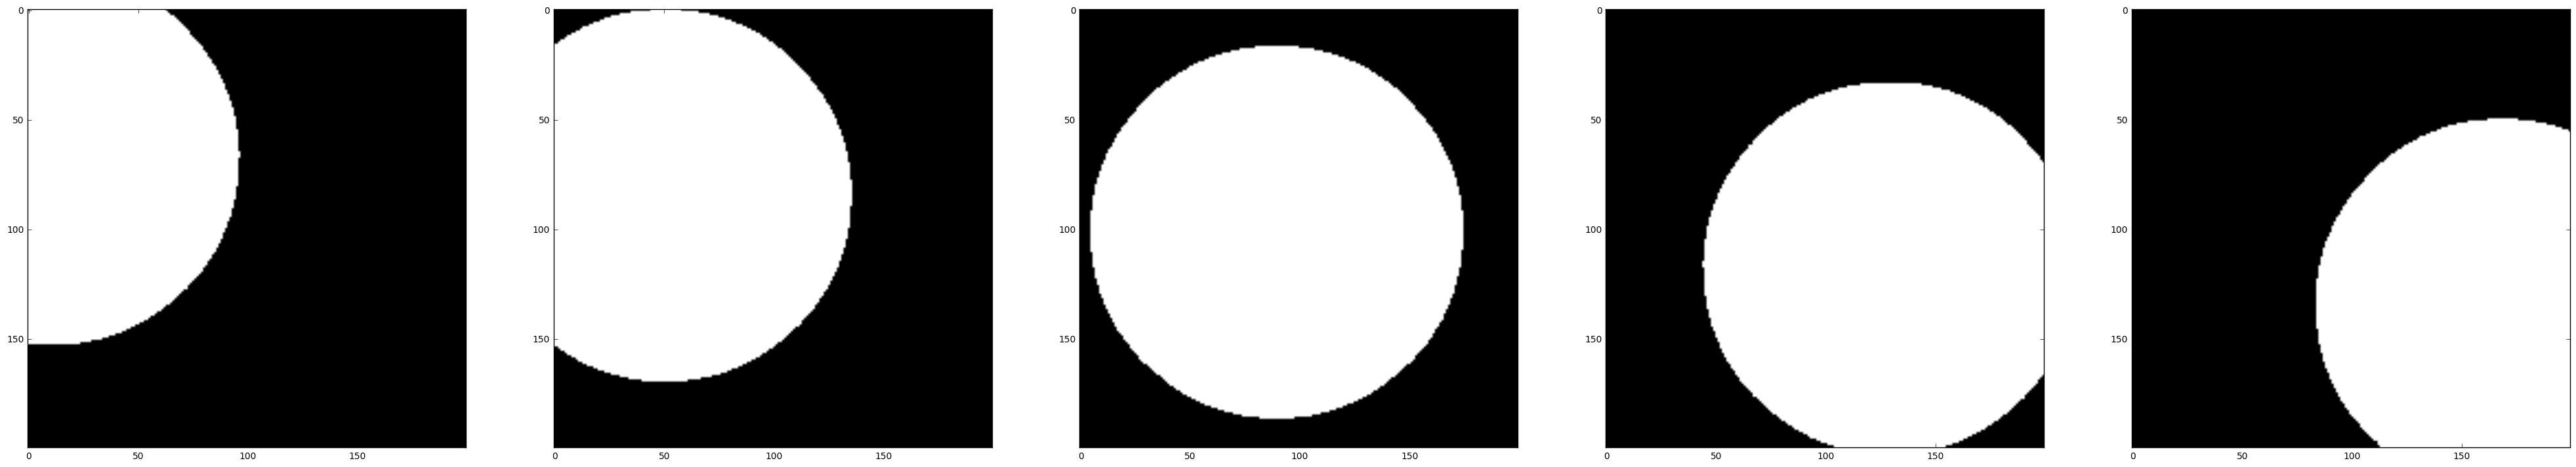

In [5]:
print 'Training data shape', train_data.shape
_, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(50,50))
ax1.imshow(train_data[2].reshape(img_width, img_width), cmap=plt.cm.Greys);
ax2.imshow(train_data[3].reshape(img_width, img_width), cmap=plt.cm.Greys);
ax3.imshow(train_data[4].reshape(img_width, img_width), cmap=plt.cm.Greys);
ax4.imshow(train_data[5].reshape(img_width, img_width), cmap=plt.cm.Greys);
ax5.imshow(train_data[6].reshape(img_width, img_width), cmap=plt.cm.Greys);